# Water content in the Active Layer Thickness

In [1]:
import numpy as np
import h5py
import os, sys
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
import pandas as pd
sys.path.remove(sys.path[0])

sys.path.append('/Users/ajc/Core/codes/simulator/debug/ats/tools/utils/')
import get_transect_data

sys.path.append('/Users/ajc/Core/PreProcessing/PyScript')
import readdata

In [3]:
path = "/Users/ajc/Core/simulations/barrow_icewedges/hydrologic_connection/ProjectionsP/"

In [19]:
#Dec 15, 2020: ProjectionsO
Simulations = [['CESM_C2%s'%i for i in range(3)], ['CESM_C1%s'%i for i in range(4)],['CESM_C3%sX'%i for i in range(3)] ]# modified rain model, dessicated zone =0.1, longwaves
Sim_name = ['S1','S2','S3']
print (Simulations)

[['CESM_C20', 'CESM_C21', 'CESM_C22'], ['CESM_C10', 'CESM_C11', 'CESM_C12', 'CESM_C13'], ['CESM_C30X', 'CESM_C31X', 'CESM_C32X']]


In [20]:
def getData(i,var_):
    Data = []
    Time = []
    for s in Simulations[i]:
        infile = os.path.join(path,s)
        
        Tim1, Dat1 = get_transect_data.get2DMatrix(infile,varnames=[var_])
        a1 = len(Dat1[0,:,0,0])%73
        a2 = len(Dat1[0,:,0,0]) - a1
        
        Tim = Tim1[:a2]
        Dat = Dat1[:,:a2,:,:]
        Time.append(Tim)
        Data.append(Dat)     
    d = dict()
    key_v = Sim_name[i] + '_' + var_
    key_t = Sim_name[i] + '_' + 'time'
    d[key_v] = Data
    d[key_t] = Time
    
    return d

In [21]:
#[nvar-1,i,j,zlen-depth_s:zlen-depth_e]
#d1 = getData(0)

In [22]:
from multiprocessing import Pool
from functools import partial
num_processors = 3
pool=Pool(processes = num_processors)

def call_data(var):
    global DataS1, DataS2, DataS3
    prod_x=partial(getData, var_=var)
    DataS1, DataS2, DataS3 = pool.map(prod_x,[i for i in range(len(Simulations))])
    Data = [DataS1, DataS2,DataS3]
    return Data

3 493 45 85
3 493 45 85
3 2467 45 85
3 2029 45 85
3 4990 45 85
3 4515 45 85
3 73 45 85
3 1533 45 85
3 4481 45 85
3 73 45 85
3 493 45 85
3 493 45 85
3 2467 45 85
3 2029 45 85
3 4990 45 85
3 4515 45 85
3 1533 45 85
3 73 45 85
3 4481 45 85
3 73 45 85
3 493 45 85
3 493 45 85
3 2467 45 85
3 2029 45 85
3 4990 45 85
3 4515 45 85
3 1533 45 85
3 73 45 85
3 4481 45 85
3 73 45 85
3 493 45 85
3 493 45 85
3 2467 45 85
3 2029 45 85
3 4990 45 85
3 1533 45 85
3 4515 45 85
3 73 45 85
3 4481 45 85
3 73 45 85


In [23]:
def getData_All(var):
    DataSimOrig = dict()
    DataWC = call_data(var)
    DataTemp = call_data(var='temperature')
    DataPor = call_data(var='base_porosity')
    DataSat = call_data(var='saturation_liquid')
    DataVol = call_data(var='cell_volume')
    for i in range(len(Sim_name)): #number of simulations
        data_wc = []
        L = len(Simulations[i])
        Time = []
        Wcontent  = []
        for k in range(L): #k is for the number of directories for a simulation
            key = list(DataWC[i].keys())[0] #[0] ='water_content', [1] = 'time'
            key_temp = list(DataTemp[i].keys())[0]
            key_time = list(DataWC[i].keys())[1] 
            key_por = list(DataPor[i].keys())[0]
            key_sat = list(DataSat[i].keys())[0]
            key_vol = list(DataVol[i].keys())[0]
            #print (i, key)
            data_time = np.array(DataWC[i][key_time][k])
            data_wc = np.array(DataWC[i][key][k])
            data_por = np.array(DataPor[i][key_por][k])
            data_sat = np.array(DataSat[i][key_sat][k])
            data_vol = np.array(DataVol[i][key_vol][k])
            
            data_temp = np.array(DataTemp[i][key_temp][k])
            
            print (data_wc.shape,data_temp.shape,data_time.shape)
            nvar, cycles, xnum, znum = data_wc.shape

            count = 1
            count_summer = 0
            sum1 = 0
            for cyc in range(cycles):
                temp_index = np.where(data_temp[nvar-1,cyc,:,:] >= 273.15)
                dat = data_wc[nvar-1,cyc,:,:][temp_index]
                sum1 = sum1 + np.sum(dat)
                if (len(temp_index[0]) > 0):
                    print ('TotalLength: ', len(temp_index[0]), temp_index)
                    break
                if (count%73 == 0):
                    sum1 = sum1/(73.-count_summer)
                    Wcontent.append(sum1/55555.)
                    Time.append(data_time[cyc])
                    sum1 = 0
                count = count + 1
                
        DataSimOrig[Sim_name[i] + '_water_content'] = np.array(Wcontent)
        DataSimOrig[Sim_name[i] + '_time'] = np.array(Time)
    return DataSimOrig

In [24]:
def getDataMoisture_All(var):
    DataSimOrig = dict()
    #DataWC = call_data(var)
    DataTemp = call_data(var='temperature')
    DataPor = call_data(var='base_porosity')
    DataSat = call_data(var='saturation_liquid')
    DataVol = call_data(var='cell_volume')
    for i in range(len(Sim_name)): #number of simulations
        #data_wc = []
        L = len(Simulations[i])
        Time = []
        Wcontent  = []
        Ccount = []
        for k in range(L): #k is for the number of directories for a simulation
            #key = list(DataWC[i].keys())[0] #[0] ='water_content', [1] = 'time'
            key_temp = list(DataTemp[i].keys())[0]
            key_time = list(DataTemp[i].keys())[1] 
            key_por = list(DataPor[i].keys())[0]
            key_sat = list(DataSat[i].keys())[0]
            key_vol = list(DataVol[i].keys())[0]
            #print (i, key)
            data_time = np.array(DataTemp[i][key_time][k])
            #data_wc = np.array(DataWC[i][key][k])
            data_por = np.array(DataPor[i][key_por][k])
            data_sat = np.array(DataSat[i][key_sat][k])
            data_vol = np.array(DataVol[i][key_vol][k])
            
            data_temp = np.array(DataTemp[i][key_temp][k])
            
            print (data_por.shape,data_temp.shape,data_time.shape)
            nvar, cycles, xnum, znum = data_temp.shape

            count = 1
            count_summer = 0
            sum1 = 0
            sum1_vec = []
            
            for cyc in range(cycles):
                temp_index = np.where(data_temp[nvar-1,cyc,:,:] >= 273.15)
                temp_index_z0 = np.where(data_temp[nvar-1,cyc,10,:] >= 273.15)
               
                
                #if (len(temp_index[0]) > 0):# and temp_index_z0[-1][0] == 84):
                if (len(temp_index_z0[0]) > 0 and temp_index_z0[-1][-1] == 84):
                    
                    #break
                    #print ('T:', temp_index_z0)
                    por = data_por[nvar-1,cyc,:,:][temp_index]
                    sat = data_sat[nvar-1,cyc,:,:][temp_index]
                    vol = data_vol[nvar-1,cyc,:,:][temp_index]
                
                    v1 = [x1*y1*z1 for x1,y1,z1 in zip(por,sat,vol)]
                    sum1 = sum1 + np.sum(v1)
                    count_summer = count_summer + 5/5.
                    sum1_vec.append(np.sum(v1))
                        
                count = count + 1
                if (count%73 == 0):
                    #print (k, count_summer)
                    sum1 = sum1/count_summer
                    Ccount.append(count_summer)
                    #sum1 = np.max(sum1_vec)
                    #print ('S1c:',sum1, sum1_vec)
                    #break
                    Wcontent.append(sum1)
                    Time.append(data_time[cyc])
                    sum1 = 0
                    sum1_vec = []
                    count_summer = 0
        print (i, Ccount)
        #print (i, len(Wcontent), len(Time), Time[0], Time[-1],count_summer)
        DataSimOrig[Sim_name[i] + '_water_content'] = np.array(Wcontent)
        DataSimOrig[Sim_name[i] + '_time'] = np.array(Time)
    return DataSimOrig

In [25]:
DataSim = getDataMoisture_All(var='water_content')

(3, 438, 45, 85) (3, 438, 45, 85) (438,)
(3, 4964, 45, 85) (3, 4964, 45, 85) (4964,)
(3, 1533, 45, 85) (3, 1533, 45, 85) (1533,)
0 [21.0, 23.0, 22.0, 22.0, 24.0, 23.0, 27.0, 21.0, 27.0, 23.0, 24.0, 23.0, 28.0, 26.0, 27.0, 28.0, 29.0, 24.0, 28.0, 20.0, 29.0, 26.0, 27.0, 34.0, 26.0, 25.0, 24.0, 30.0, 32.0, 29.0, 26.0, 28.0, 25.0, 29.0, 33.0, 27.0, 30.0, 32.0, 28.0, 31.0, 31.0, 32.0, 26.0, 33.0, 28.0, 29.0, 32.0, 33.0, 29.0, 33.0, 30.0, 35.0, 30.0, 30.0, 35.0, 30.0, 30.0, 26.0, 35.0, 36.0, 32.0, 32.0, 35.0, 32.0, 32.0, 36.0, 34.0, 34.0, 36.0, 35.0, 40.0, 33.0, 34.0, 35.0, 35.0, 34.0, 35.0, 39.0, 36.0, 32.0, 35.0, 38.0, 38.0, 32.0, 40.0, 43.0, 32.0, 32.0, 31.0, 36.0, 40.0, 36.0, 37.0, 38.0, 41.0]
(3, 438, 45, 85) (3, 438, 45, 85) (438,)
(3, 1971, 45, 85) (3, 1971, 45, 85) (1971,)
(3, 4453, 45, 85) (3, 4453, 45, 85) (4453,)
(3, 73, 45, 85) (3, 73, 45, 85) (73,)
1 [21.0, 23.0, 22.0, 22.0, 23.0, 23.0, 28.0, 22.0, 29.0, 22.0, 24.0, 23.0, 28.0, 30.0, 27.0, 29.0, 29.0, 24.0, 28.0, 20.0, 29.0, 27

In [26]:
def get_moving_average(d, m=5):
    d_avg = []
    len1 = len(d)
    for i in range(len1):
        if i < m:
            s1 = np.mean(d[:i+1])
        else:
            s1= np.mean(d[i-m:i])

        d_avg.append(s1)
    return d_avg

In [27]:
to_day_year_mm = (86400 * 365) *1000 
to_day_mm = (86400) *1000
to_year = 365
def getSurfaceData(i):
    Data = []
    var ='surface-water_content'
    for s in Simulations[i]:
        infile = os.path.join(path,s,'visdump_surface_data.h5')
        dx=h5py.File(infile,'r')
        Dat11 = np.array(readdata.GetSurfVarFromVis_All(infile,var)[var])
        Dat11 = Dat11.mean(axis=1)/55300.
        a1 = len(Dat11)%73
        a2 = len(Dat11) - a1

        Dat = Dat11[:a2]
        Data.append(Dat)
        
    d = dict()
    d[var] = np.concatenate(Data)
    
    return d

In [28]:
from multiprocessing import Pool
from functools import partial
num_processors = 3
pool=Pool(processes = num_processors)

def call_data_surface():
    global DataSurf1, DataSurf2, DataSurf3
    prod_x=partial(getSurfaceData)
    DataSurf1, DataSurf2, DataSurf3 = pool.map(prod_x,[i for i in range(len(Simulations))])
    Data = [DataSurf1, DataSurf2, DataSurf3]
    return Data

In [29]:
DataSimSurf =  call_data_surface()

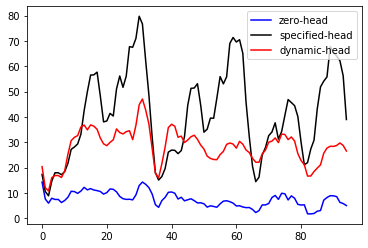

In [30]:
Labels = ['zero-head','specified-head','dynamic-head']
Colors = ['b','k','r','r']
surface_area = 61.92
for i in range(3):
    d =np.reshape(DataSimSurf[i]['surface-water_content'],(-1,73)).sum(axis=1)/surface_area*1000
    d = get_moving_average(d,m=5)
    plt.plot(d,color=Colors[i],label=Labels[i])
plt.legend()
#plt.plot(DataSimSurf[1]['surface-water_content'],'k')
#plt.plot(DataSimSurf[2]['surface-water_content'],'r')

In [32]:
%matplotlib qt
outfile='/Users/ajc/Documents/MyPapers/TroughHydrodynamics/figures/Feb16_uniform_om/'
def Plot_WaterContent():
    fig, axs = plt.subplots(1,1, figsize=(5,3.5), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)
    
    plt.tight_layout()
    #axs = axs.ravel()
    xpos = np.array([0, 1,2,3])

    Labels = ['zero-head','specified-head','dynamic-head']
    
    T = ['a','b','c','d']
    Keys = list(DataSim.keys())
    Data_temp = []
    for i in range(3):
        d = DataSim[Keys[2*i]]
        dsurf =np.reshape(DataSimSurf[i]['surface-water_content'],(-1,73)).sum(axis=1)#/surface_area*1000
        
        d1 = [x+y for x,y in zip(d,dsurf)]
        d1 = [x/d1[0] for x in d1]
        d_avg5yr = get_moving_average(d1,m=5)
        print (i, len(d_avg5yr), len(d))
        #init = d1[0]#d_avg5yr[0]
        #d_avg5yr = [x/init for x in d_avg5yr]
        axs.plot(2005 + DataSim[Keys[2*i+1]], d_avg5yr,color=Colors[i],label=Labels[i])
        
        axs.set_xlim((2006, 2100))
        axs.set_xlabel('Year',fontsize=12, fontweight='normal')
        
        axs.set_ylabel('Normalized soil moisture',fontsize=12, fontweight='normal')
        axs.legend(loc='upper left',labelspacing=.1)
        Data_temp.append(d_avg5yr)
        print('---------')
    Data_temp1 = np.reshape(Data_temp,(3,-1))
    plt.savefig(outfile+'normalized-moisture_ALT-5yr_avg.pdf', bbox_inches='tight', dpi=500)
    np.savetxt(outfile+'normalized-moisture_ALT-5yr_avg.dat', Data_temp1)
    plt.show()



In [33]:
Plot_WaterContent()

0 95 95
---------
1 95 95
---------
2 95 95
---------


# STOP HERE